In [99]:
!pip install Sastrawi

^C


In [1]:
#Load library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords

In [2]:
#Load dataset
df = pd.read_csv('in_hf.csv', usecols=['text', 'labels'], encoding='utf-8')
print("Kolom dalam dataset:", df.columns.tolist())
print("Jumlah data:", len(df))
print(df['labels'].value_counts())
df.head()

Kolom dalam dataset: ['text', 'labels']
Jumlah data: 14306
labels
0    8256
1    6050
Name: count, dtype: int64


,text,labels
0,@USER.wood17 knp lo gak berani bersumpah dan b...,1
1,"haha, somad somad. Muka dekil otak 0% , kok ya...",1
2,"hahaha, kaum sableng 212 kl berita begini mrk ...",1
3,"hahaha, makin stress aja ni umat sableng, dlu...",1
4,HIDUP PSI = partai SAMPAH indonesia..... ...,1


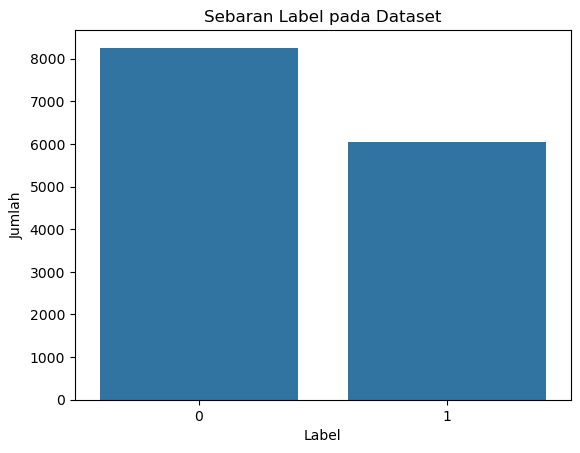

labels
0    8256
1    6050
Name: count, dtype: int64

In [3]:
#lihat sebaran label pada dataset
sns.countplot(x='labels', data=df)
plt.title('Sebaran Label pada Dataset')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()
#Cek jumlah data pada setiap label
df['labels'].value_counts()

In [130]:
#Cek missing value pada dataset
df.isnull().sum()

text      0
labels    0
dtype: int64

In [131]:
#Cek duplikasi pada baris
df.duplicated().sum()

114

In [132]:
#hapus duplikasi pada dataset
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [133]:
#hapus url
def clean_data(df):
  df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

clean_data(df)
df.head()

,text,labels
0,@USER.wood17 knp lo gak berani bersumpah dan b...,1
1,"haha, somad somad. Muka dekil otak 0% , kok ya...",1
2,"hahaha, kaum sableng 212 kl berita begini mrk ...",1
3,"hahaha, makin stress aja ni umat sableng, dlu...",1
4,HIDUP PSI = partai SAMPAH indonesia..... ...,1


In [134]:
#hapus emoji
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emotikon wajah
                           u"\U0001F300-\U0001F5FF"  # simbol & ikon
                           u"\U0001F680-\U0001F6FF"  # transport & simbol
                           u"\U0001F1E0-\U0001F1FF"  # bendera
                           u"\U00002700-\U000027BF"  # simbol tambahan
                           u"\U0001F900-\U0001F9FF"  # emoji tambahan (2017+)
                           "]+", flags=re.UNICODE)

#fungsi hapus emoji
def remove_emoji(text):
    return emoji_pattern.sub(r'', text)
df['text'] = df['text'].apply(remove_emoji)
df.head()

,text,labels
0,@USER.wood17 knp lo gak berani bersumpah dan b...,1
1,"haha, somad somad. Muka dekil otak 0% , kok ya...",1
2,"hahaha, kaum sableng 212 kl berita begini mrk ...",1
3,"hahaha, makin stress aja ni umat sableng, dlu...",1
4,HIDUP PSI = partai SAMPAH indonesia..... ...,1


In [135]:
#hapus karakter spesial
import string

def hapus_karakter_spesial(text):
    for sp in string.punctuation:
        text = text.replace(sp, " ")
    text = re.sub(r"\d+", "", text)
    return text.replace('/s+/g', ' ')
df['text'] = df['text'].apply(hapus_karakter_spesial)
df.head()

,text,labels
0,USER wood knp lo gak berani bersumpah dan ber...,1
1,haha somad somad Muka dekil otak kok ya ...,1
2,hahaha kaum sableng kl berita begini mrk but...,1
3,hahaha makin stress aja ni umat sableng dlu...,1
4,HIDUP PSI partai SAMPAH indonesia,1


In [136]:
#casefolding
df['text'] = df['text'].str.lower()
df.head()

,text,labels
0,user wood knp lo gak berani bersumpah dan ber...,1
1,haha somad somad muka dekil otak kok ya ...,1
2,hahaha kaum sableng kl berita begini mrk but...,1
3,hahaha makin stress aja ni umat sableng dlu...,1
4,hidup psi partai sampah indonesia,1


In [137]:
#hapus kata user dan rt
def hapus_user_rt(text):
    text = re.sub(r'\bUSER\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\bRT\b', '', text, flags=re.IGNORECASE)
    #hapus encoding error pada dataset
    text = re.sub(r'[�ð]', '', text)                                      #karakter spesifik yang sering muncul
    text = re.sub(r'[^\x00-\x7F]+', '', text)                               #hapus karakter non-ASCII)
    text = text.translate(str.maketrans('', '', string.punctuation))        #hapus tanda baca
    #hapus spasi berlebihan
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(hapus_user_rt)
df.head()

,text,labels
0,wood knp lo gak berani bersumpah dan bertaruh ...,1
1,haha somad somad muka dekil otak kok ya g malu...,1
2,hahaha kaum sableng kl berita begini mrk buta ...,1
3,hahaha makin stress aja ni umat sableng dlu ra...,1
4,hidup psi partai sampah indonesia,1


In [138]:
#simpan dataset hasil cleaning untuk di cek
df[['text', 'labels']].to_csv('dataset_b1.csv', index=False)

-------------------------------------------------------------------------------------------------------

In [139]:
#Membaca stopwords tambahan
stopwords_file = 'stopword_extend.txt'
with open(stopwords_file, 'r') as file:
    additional_stopwords = [line.strip() for line in file]
additional_stopwords = str(additional_stopwords).split()

#Download stopwords dari NLTK
nltk.download('stopwords')
stopword_id_factory = StopWordRemoverFactory()
sastrawi_stopwords = stopword_id_factory.get_stop_words()

#Gabungkan stopwords bawaan NLTK dengan stopwords tambahan
stop_words = stopwords.words('indonesian')
extended_stopwords = list(set(stop_words + additional_stopwords + sastrawi_stopwords))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Arciel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [140]:
#Load kamus alay
alay_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
#Rename kolom alay_dict
alay_dict = alay_dict.rename(columns={0: 'original', 1: 'replacement'})
# Create alay_dict map
alay_map = dict(zip(alay_dict['original'], alay_dict['replacement']))

# cek alay_map
print(alay_dict.head())
print(f"Total entries in kamus alay: {len(alay_map)}")

              original               replacement
0  anakjakartaasikasik  anak jakarta asyik asyik
1         pakcikdahtua         pak cik sudah tua
2       pakcikmudalagi         pak cik muda lagi
3          t3tapjokowi              tetap jokowi
4                   3x                 tiga kali
Total entries in kamus alay: 15167


In [141]:
#Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

-------------------------------------------------------------------------------------------------------

In [142]:
#hapus stopwords
def remove_stopwords(text):
    words = text.split()
    cleaned_words = [word for word in words if word not in extended_stopwords]
    return ' '.join(cleaned_words)

df['text'] = df['text'].apply(remove_stopwords)
df.head()

,text,labels
0,wood knp gak berani bersumpah bertaruh krnlo p...,1
1,haha somad somad muka dekil otak g malu ngaku ...,1
2,hahaha kaum sableng kl berita mrk buta tuli,1
3,hahaha stress aja ni umat sableng dlu raja sal...,1
4,hidup psi partai sampah indonesia,1


In [143]:
#normalisasi kata dengan kamus alay
def normalize_alay(text):
    words = text.split()
    normalize_words = [alay_map.get(word, word) for word in words]
    return ' '.join(normalize_words)

df['text'] = df['text'].apply(normalize_alay)
df.head()

,text,labels
0,wood kenapa tidak berani bersumpah bertaruh kr...,1
1,haha somad somad muka dekil otak tidak malu me...,1
2,haha kaum sableng kalau berita mereka buta tuli,1
3,haha stres saja nih umat sableng dulu raja sal...,1
4,hidup psi partai sampah indonesia,1


In [144]:
from tqdm.auto import tqdm
tqdm.pandas()
#stemming
def stemming(text):
    return stemmer.stem(text)

df['text'] = df['text'].progress_apply(stemming)
df.head()

  0%|          | 0/14192 [00:00<?, ?it/s]

,text,labels
0,wood kenapa tidak berani sumpah taruh krnlo cu...,1
1,haha somad somad muka dekil otak tidak malu ak...,1
2,haha kaum sableng kalau berita mereka buta tuli,1
3,haha stres saja nih umat sableng dulu raja sal...,1
4,hidup psi partai sampah indonesia,1


In [146]:
#Cek missing value pada dataset
df.isnull().sum()

text      0
labels    0
dtype: int64

In [147]:
#hapus space berlebihan setelah stemming
def poststemming(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['text'] = df['text'].progress_apply(poststemming)
df.head()

  0%|          | 0/14192 [00:00<?, ?it/s]

,text,labels
0,wood kenapa tidak berani sumpah taruh krnlo cu...,1
1,haha somad somad muka dekil otak tidak malu ak...,1
2,haha kaum sableng kalau berita mereka buta tuli,1
3,haha stres saja nih umat sableng dulu raja sal...,1
4,hidup psi partai sampah indonesia,1


In [148]:
#simpan dataset hasil preprocessing
df[['text', 'labels']].to_csv('datasetfinal.csv', index=False)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
#cek dataset kembali sesudah preprocessing
df = pd.read_csv('datasetfinal.csv', encoding='utf-8')

#cek kembali missing value pada dataset setelah stemming pada pre-processing
df.isnull().sum()

text      21
labels     0
dtype: int64

In [6]:
df.dropna(subset=['text'], inplace=True)

In [7]:
#cek kembali missing value 
df.isnull().sum()

text      0
labels    0
dtype: int64

In [8]:
#simpan dataset yang telah difix
df[['text', 'labels']].to_csv('datasetfinal.csv', index=False)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
#Load dataset
df = pd.read_csv('datasetfinal.csv', usecols=['text', 'labels'], encoding='utf-8')
print("Kolom dalam dataset:", df.columns.tolist())
print("Jumlah data:", len(df))
print(df['labels'].value_counts())
df.head()

Kolom dalam dataset: ['text', 'labels']
Jumlah data: 14171
labels
0    8237
1    5934
Name: count, dtype: int64


,text,labels
0,wood kenapa tidak berani sumpah taruh krnlo cu...,1
1,haha somad somad muka dekil otak tidak malu ak...,1
2,haha kaum sableng kalau berita mereka buta tuli,1
3,haha stres saja nih umat sableng dulu raja sal...,1
4,hidup psi partai sampah indonesia,1


In [5]:
# Mengurangi jumlah hate speech menjadi 10% dari jumlah non-hate speech untuk revisi 1
# Pisahkan berdasarkan label
non_hate_df = df[df['labels'] == 0]
hate_df = df[df['labels'] == 1]

# Hitung 10% dari jumlah non-hate speech
target_hate_count = int(0.1 * len(non_hate_df))

# Ambil sampel dari hate speech
reduced_hate_df = hate_df.sample(n=target_hate_count, random_state=42)

# Gabungkan kembali
balanced_df = pd.concat([non_hate_df, reduced_hate_df])

# Acak ulang dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Simpan hasilnya ke CSV baru (opsional)
balanced_df.to_csv("dataset_reduced.csv", index=False)


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
#Load dataset
df = pd.read_csv('datasetfinal.csv', usecols=['text', 'labels'], encoding='utf-8')
print("Kolom dalam dataset:", df.columns.tolist())
print("Jumlah data:", len(df))
print(df['labels'].value_counts())
df.head()

Kolom dalam dataset: ['text', 'labels']
Jumlah data: 14171
labels
0    8237
1    5934
Name: count, dtype: int64


,text,labels
0,wood kenapa tidak berani sumpah taruh krnlo cu...,1
1,haha somad somad muka dekil otak tidak malu ak...,1
2,haha kaum sableng kalau berita mereka buta tuli,1
3,haha stres saja nih umat sableng dulu raja sal...,1
4,hidup psi partai sampah indonesia,1


In [6]:
# Mengurangi jumlah hate speech menjadi 10% dari jumlah non-hate speech untuk revisi 1
# Pisahkan berdasarkan label
non_hate_df = df[df['labels'] == 0]
hate_df = df[df['labels'] == 1]

# Hitung 10% dari jumlah non-hate speech
target_hate_count = int(0.3 * len(non_hate_df))

# Ambil sampel dari hate speech
reduced_hate_df = hate_df.sample(n=target_hate_count, random_state=42)

# Gabungkan kembali
balanced_df = pd.concat([non_hate_df, reduced_hate_df])

# Acak ulang dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Simpan hasilnya ke CSV baru (opsional)
balanced_df.to_csv("dataset_reduced_30.csv", index=False)